In [1]:
# scripts/load_data.py

import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine


# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

def load_data_from_postgres(query):
    """
    Connects to the PostgreSQL database and loads data based on the provided SQL query.

    :param query: SQL query to execute.
    :return: DataFrame containing the results of the query.
    """
    try:
        # Establish a connection to the database
        connection = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )

        # Load data using pandas
        df = pd.read_sql_query(query, connection)

        # Close the database connection
        connection.close()

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None



def load_data_using_sqlalchemy(query):
    """
    Connects to the PostgreSQL database and loads data based on the provided SQL query using SQLAlchemy.

    :param query: SQL query to execute.
    :return: DataFrame containing the results of the query.
    """
    try:
        # Create a connection string
        connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

        # Create an SQLAlchemy engine
        engine = create_engine(connection_string)

        # Load data into a pandas DataFrame
        df = pd.read_sql_query(query, engine)

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns['% of Total Values'] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns



def outliers_table(df):
    # Initialize empty lists to store results
    outliers_info = []
    
    # Iterate through numerical columns
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Z-scores
        z_scores = np.abs(zscore(df[col].dropna()))
        
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Z-score method
        z_score_outliers = (z_scores > 3).sum()
        
        # IQR method
        iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        
        # Append results
        outliers_info.append({
            'Column': col,
            'Z-Score Outliers': z_score_outliers,
            'IQR Outliers': iqr_outliers
        })
    
    # Convert results to DataFrame
    outliers_table_df = pd.DataFrame(outliers_info)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "Outlier information for numerical columns is displayed below.")
    
    # Return the dataframe with outlier information
    return outliers_table_df


def convert_bytes_to_megabytes(df, bytes_data):
    megabyte = 1e+6  # 1 MB = 1e+6 Bytes
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]


def fix_outlier(df, column, percentile=0.95):
    threshold = df[column].quantile(percentile)
    median = df[column].median()
    df[column] = np.where(df[column] > threshold, median, df[column])
    return df[column]


def remove_outliers(df, column_to_process, z_threshold=3):
    # Apply outlier removal to the specified column
    df = df.copy()  # Avoid modifying the original DataFrame
    z_scores = zscore(df[column_to_process].dropna())
    df['z_score'] = np.nan
    df.loc[df[column_to_process].notna(), 'z_score'] = z_scores

    outlier_column = column_to_process + '_Outlier'
    df[outlier_column] = (np.abs(df['z_score']) > z_threshold).astype(int)
    df = df[df[outlier_column] == 0]  # Keep rows without outliers

    # Drop the outlier column as it's no longer needed
    df = df.drop(columns=[outlier_column, 'z_score'], errors='ignore')

    return df

In [3]:
import pandas as pd
import psycopg2

def load_data_from_postgres(query, db_params):
    """
    Load data from PostgreSQL into a Pandas DataFrame.
    
    Parameters:
    - query: SQL query to execute.
    - db_params: Dictionary containing database connection parameters.
    
    Returns:
    - DataFrame containing the query results.
    """
    try:
        # Establish the connection
        conn = psycopg2.connect(**db_params)
        
        # Load data into DataFrame
        df = pd.read_sql_query(query, conn)
        
        # Close the connection
        conn.close()
        
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Define database connection parameters
db_params = {
    'dbname': 'my_database',
    'user': 'ayalk',
    'password': '12345678',
    'host': 'localhost',
    'port': '5432'
}

# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query, db_params)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
    print(df.head())
else:
    print("Failed to load data.")


/tmp/ipykernel_5854/3617078604.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Successfully loaded the data
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          2024

### Task 3.1: Aggregate Per Customer Information

In [6]:
import pandas as pd

# Filling missing values in a safer way without chained assignment
df['TCP DL Retrans. Vol (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'].fillna(df['TCP DL Retrans. Vol (Bytes)'].mean())
df['Avg RTT DL (ms)'] = df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean())
df['Avg Bearer TP DL (kbps)'] = df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean())
df['Handset Type'] = df['Handset Type'].fillna(df['Handset Type'].mode()[0])

# Aggregating by customer
agg_data = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Handset Type': 'first'
}).reset_index()

# Renaming columns for clarity
agg_data.columns = ['Customer ID', 'Avg TCP Retransmission', 'Avg RTT', 'Avg Throughput', 'Handset Type']

# Display the result
print(agg_data.head())


    Customer ID  Avg TCP Retransmission     Avg RTT  Avg Throughput  \
0  3.360100e+10            2.080991e+07   46.000000            37.0   
1  3.360100e+10            2.080991e+07   30.000000            48.0   
2  3.360100e+10            2.080991e+07  109.795706            48.0   
3  3.360101e+10            1.066000e+03   69.000000           204.0   
4  3.360101e+10            1.507977e+07   57.000000         20197.5   

                     Handset Type  
0  Huawei P20 Lite Huawei Nova 3E  
1          Apple iPhone 7 (A1778)  
2                       undefined  
3         Apple iPhone 5S (A1457)  
4         Apple iPhone Se (A1723)  


### Task 3.2: Compute & List Top, Bottom, and Most Frequent Values

In [7]:
# Top, bottom, and most frequent values for TCP Retransmission
top_tcp = agg_data['Avg TCP Retransmission'].nlargest(10)
bottom_tcp = agg_data['Avg TCP Retransmission'].nsmallest(10)
most_frequent_tcp = agg_data['Avg TCP Retransmission'].mode()[0]

# Top, bottom, and most frequent values for RTT
top_rtt = agg_data['Avg RTT'].nlargest(10)
bottom_rtt = agg_data['Avg RTT'].nsmallest(10)
most_frequent_rtt = agg_data['Avg RTT'].mode()[0]

# Top, bottom, and most frequent values for Throughput
top_throughput = agg_data['Avg Throughput'].nlargest(10)
bottom_throughput = agg_data['Avg Throughput'].nsmallest(10)
most_frequent_throughput = agg_data['Avg Throughput'].mode()[0]

# Display the results
print("Top 10 TCP Retransmission:", top_tcp)
print("Bottom 10 TCP Retransmission:", bottom_tcp)
print("Most Frequent TCP Retransmission:", most_frequent_tcp)

print("Top 10 RTT:", top_rtt)
print("Bottom 10 RTT:", bottom_rtt)
print("Most Frequent RTT:", most_frequent_rtt)

print("Top 10 Throughput:", top_throughput)
print("Bottom 10 Throughput:", bottom_throughput)
print("Most Frequent Throughput:", most_frequent_throughput)


Top 10 TCP Retransmission: 85785    4.289488e+09
32273    4.288060e+09
58026    4.268432e+09
31942    4.254644e+09
62049    4.211189e+09
70079    4.166591e+09
43629    4.131046e+09
48341    4.117753e+09
64113    3.968072e+09
98211    3.785295e+09
Name: Avg TCP Retransmission, dtype: float64
Bottom 10 TCP Retransmission: 56622     2.0
95322     2.0
71705     4.0
71778     4.0
87156     4.0
87348     4.0
95213     4.0
95331     4.0
95774     4.0
100616    4.0
Name: Avg TCP Retransmission, dtype: float64
Most Frequent TCP Retransmission: 20809914.27034193
Top 10 RTT: 47983     96923.0
80249     54847.0
41944     32333.0
93844     26971.0
1713      26250.0
74240     25602.0
104325    25374.0
105752    24733.0
85683     22961.5
15409     20979.0
Name: Avg RTT, dtype: float64
Bottom 10 RTT: 28878     0.0
40873     0.0
44748     0.0
66098     0.0
88903     0.0
98541     0.0
39066     2.0
83396     4.0
36039     5.0
106569    5.0
Name: Avg RTT, dtype: float64
Most Frequent RTT: 109.79570605376

### Task 3.3: Distribution of Experience Metrics Per Handset Type

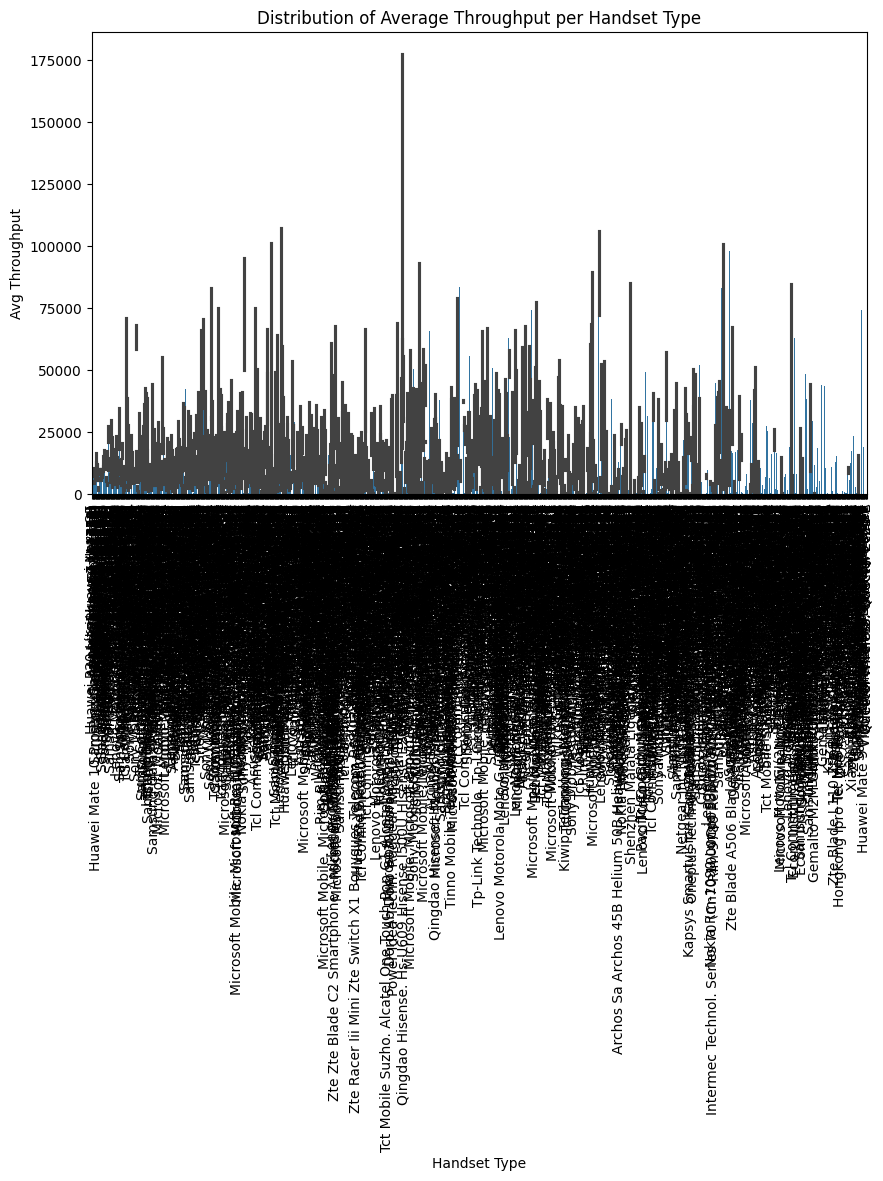

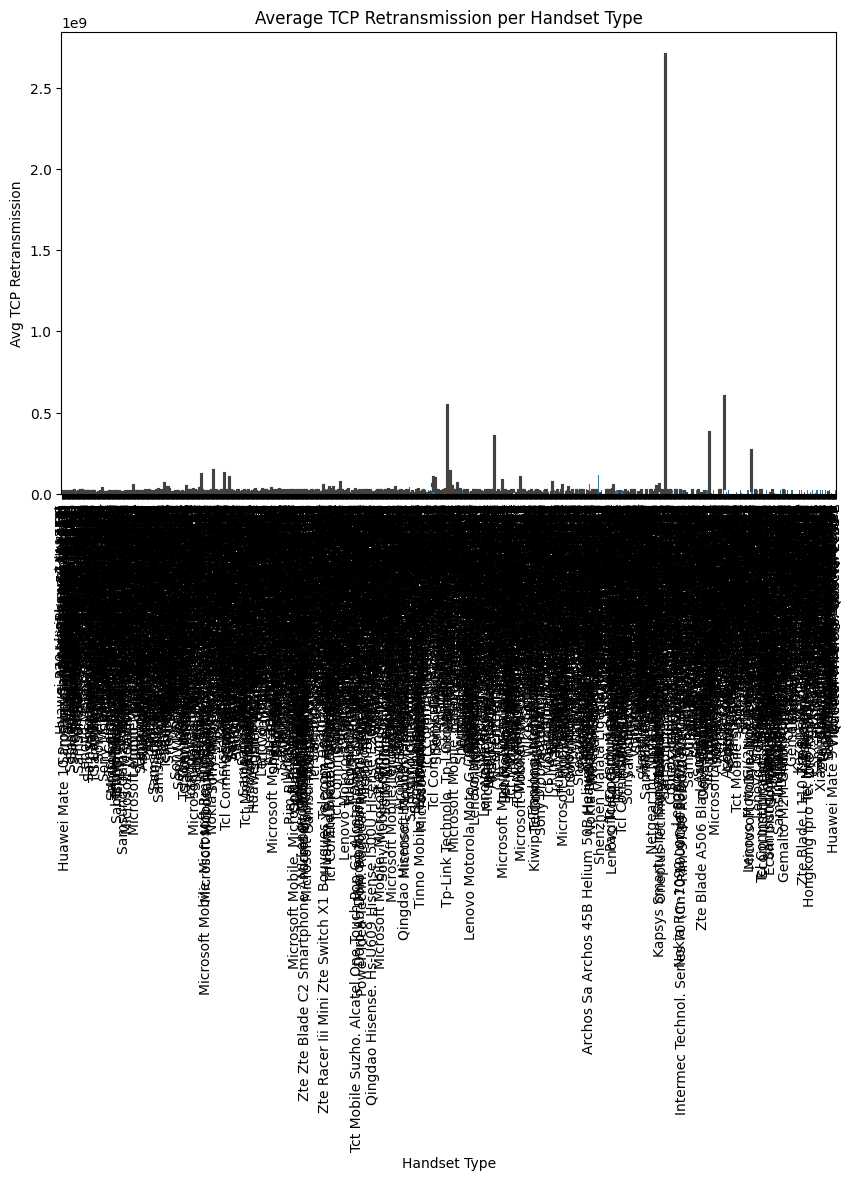

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Throughput per Handset Type
plt.figure(figsize=(10, 6))
sns.barplot(x='Handset Type', y='Avg Throughput', data=agg_data)
plt.title('Distribution of Average Throughput per Handset Type')
plt.xticks(rotation=90)
plt.show()

# TCP Retransmission per Handset Type
plt.figure(figsize=(10, 6))
sns.barplot(x='Handset Type', y='Avg TCP Retransmission', data=agg_data)
plt.title('Average TCP Retransmission per Handset Type')
plt.xticks(rotation=90)
plt.show()


### Task 3.4: K-means Clustering for User Segmentation

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X = scaler.fit_transform(agg_data[['Avg TCP Retransmission', 'Avg RTT', 'Avg Throughput']])

# Applying k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agg_data['Experience Cluster'] = kmeans.fit_predict(X)

# Describing each cluster
for cluster in range(3):
    print(f"Cluster {cluster + 1} statistics:")
    print(agg_data[agg_data['Experience Cluster'] == cluster].describe())


Cluster 1 statistics:
        Customer ID  Avg TCP Retransmission       Avg RTT  Avg Throughput  \
count  1.824400e+04            1.824400e+04  18244.000000    18244.000000   
mean   3.367763e+10            1.959627e+07     77.319787    49171.539659   
std    4.385404e+07            7.768724e+07    112.742139    22735.042041   
min    3.360103e+10            3.100000e+01     15.000000    25526.666667   
25%    3.365876e+10            5.235614e+05     40.729167    33396.000000   
50%    3.366429e+10            3.684858e+06     56.000000    42624.500000   
75%    3.368641e+10            1.133274e+07     80.286963    57497.750000   
max    3.378998e+10            1.118514e+09   5379.000000   264448.000000   

       Experience Cluster  
count             18244.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0  
Cluster 2 statistics:
        Cu